In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import glob
import gc
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.keras import backend as K
import seaborn as sns

In [2]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 10

def extract_image_info(filepath):
    img = cv2.imread(filepath)
    h, w, c = img.shape
    img_class = os.path.basename(os.path.dirname(filepath)).split('.')[-1]
    return [w, h, img_class]

def create_embedding_model():
    base_cnn = applications.inception_resnet_v2.InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
        
    x = layers.GlobalAveragePooling2D()(base_cnn.output)
    x = layers.Dense(1024, activation='relu')(x)  
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(128)(x)
    output = layers.Lambda(lambda x: K.l2_normalize(x, axis=-1))(output)  # Add L2 normalization

    return Model(inputs=base_cnn.input, outputs=output)

def load_image(image_path, img_size=IMG_SIZE):
    img = plt.imread(image_path)
    img = np.array(Image.fromarray(img).resize(img_size, resample=Image.BILINEAR))
    return img / 255.0

def data_generator(data_df, batch_size=BATCH_SIZE):
    while True:
        data_df = data_df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
        for i in range(0, len(data_df), batch_size):
            batch_df = data_df[i:i + batch_size]
            anchor_batch, positive_batch, negative_batch = [], [], []
            for _, row in batch_df.iterrows():
                anchor_img_path = row['filepath']
                anchor_dog_id = row['DogID']

                # Get positive image
                positive_df = data_df[data_df['DogID'] == anchor_dog_id].sample(n=2)
                positive_row = positive_df.iloc[0] if positive_df.iloc[0]['filepath'] != anchor_img_path else positive_df.iloc[1]
                positive_img_path = positive_row['filepath']

                # Get negative image
                negative_df = data_df[data_df['DogID'] != anchor_dog_id].sample(1)
                negative_img_path = negative_df.iloc[0]['filepath']

                anchor_batch.append(load_image(anchor_img_path))
                positive_batch.append(load_image(positive_img_path))
                negative_batch.append(load_image(negative_img_path))

            anchor_batch = np.array(anchor_batch)
            positive_batch = np.array(positive_batch)
            negative_batch = np.array(negative_batch)
            dummy_labels = np.zeros((batch_size, 1)) # Add dummy labels
            yield [anchor_batch, positive_batch, negative_batch], dummy_labels

In [3]:
# Define the Euclidean distance function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

# Define the triplet loss function
def triplet_loss(_, y_pred):
    margin = 1
    anchor_positive_distance, anchor_negative_distance = y_pred[:, 0], y_pred[:, 1]
    loss = tf.maximum(anchor_positive_distance - anchor_negative_distance + margin, 0.0)
    return tf.reduce_mean(loss)

def triplet_accuracy(_, y_pred):
    anchor_positive_distance, anchor_negative_distance = y_pred[:, 0], y_pred[:, 1]
    return tf.reduce_mean(tf.cast(anchor_positive_distance < anchor_negative_distance, tf.float32))

def create_siamese_model(embedding_model):
    anchor_input = layers.Input(shape=(*IMG_SIZE, 3))
    positive_input = layers.Input(shape=(*IMG_SIZE, 3))
    negative_input = layers.Input(shape=(*IMG_SIZE, 3))

    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    positive_distance = layers.Lambda(euclidean_distance)([anchor_embedding, positive_embedding])
    negative_distance = layers.Lambda(euclidean_distance)([anchor_embedding, negative_embedding])

    stacked_dists = layers.Concatenate()([positive_distance, negative_distance])
    siamese_model = Model([anchor_input, positive_input, negative_input], stacked_dists)

    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=triplet_loss, metrics=[triplet_accuracy])
    return siamese_model


In [4]:
def evaluation(history):
    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['triplet_accuracy']
    val_acc = history['val_triplet_accuracy']
    
    epochs = np.arange(len(loss))
    fig = plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, '-o', label="triplet_loss")
    plt.plot(epochs, val_loss, '-o', label="val_triplet_loss")
    plt.xlabel("Number of epochs")
    plt.yticks(np.arange(0, 8, 1))
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, '-o', label="triplet_accuracy")
    plt.plot(epochs, val_acc, '-o', label="val_triplet_accuracy")
    plt.xlabel("Number of epochs")
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid()
    plt.legend()
    fig.savefig('/kaggle/working/eval.jpg', dpi=300)

In [5]:
# Load and split the dataframe
path_list_test = [path for path in glob.glob('/kaggle/input/dogdataset/Gallory_diffCamera/**/*.jpg', recursive = True)]
print(f"Total test images: {len(path_list_test)}")

df_test = pd.DataFrame(path_list_test,columns=['filepath'])

path_list_train = [path for path in glob.glob('/kaggle/input/dogdataset/Gallery_sameCamera/**/*.jpg', recursive = True)]
print(f"Total train images: {len(path_list_train)}")

df = pd.DataFrame(path_list_train,columns=['filepath'])

df[['W', 'H', 'DogID']] = pd.DataFrame(df['filepath'].apply(extract_image_info).to_list())

Total test images: 3871
Total train images: 6504


In [6]:
df

,filepath,W,H,DogID
0,/kaggle/input/dogdataset/Gallery_sameCamera/Do...,276,183,0303
1,/kaggle/input/dogdataset/Gallery_sameCamera/Do...,211,193,0303
2,/kaggle/input/dogdataset/Gallery_sameCamera/Do...,193,189,0303
3,/kaggle/input/dogdataset/Gallery_sameCamera/Do...,215,189,0303
4,/kaggle/input/dogdataset/Gallery_sameCamera/Do...,260,182,0303
...,...,...,...,...
6499,/kaggle/input/dogdataset/Gallery_sameCamera/Do...,60,41,0101
6500,/kaggle/input/dogdataset/Gallery_sameCamera/Do...,51,32,0101
6501,/kaggle/input/dogdataset/Gallery_sameCamera/Do...,31,44,0101
6502,/kaggle/input/dogdataset/Gallery_sameCamera/Do...,43,44,0101


<AxesSubplot:>

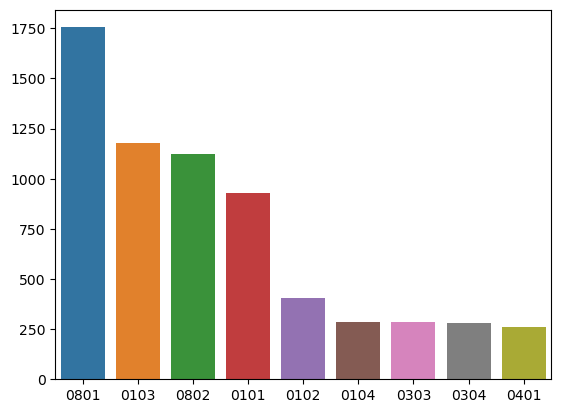

In [7]:
dog_counts = df['DogID'].value_counts()
sns.barplot(x=dog_counts.index, y=dog_counts.values)

In [8]:
#remove some outlier
W,H = df.describe()['W'], df.describe()['H']
IQR_W = W['75%'] - W['25%']
IQR_H = H['75%'] - H['25%']

IQR = (IQR_W, IQR_H)
IQR_W_RANGE = W['25%'] - IQR_W*1.5, W['75%'] + IQR_W*1.5
IQR_H_RANGE = W['25%'] - IQR_H*1.5, W['75%'] + IQR_H*1.5

df = df[(df['W'] >= IQR_W_RANGE[0]) & (df['W'] <= IQR_W_RANGE[1])]
df = df[(df['H'] >= IQR_H_RANGE[0]) & (df['H'] <= IQR_H_RANGE[1])]

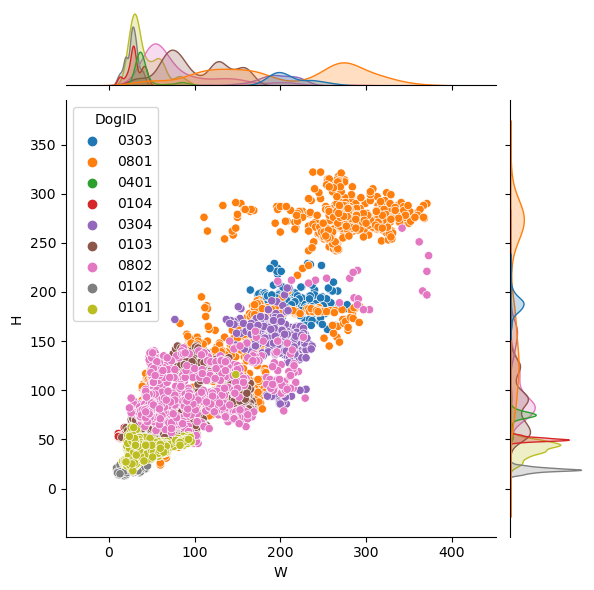

In [9]:
sns.jointplot(data=df, x="W", y="H", kind="scatter",hue = 'DogID')

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=123, stratify=df['DogID'])

In [11]:
from tensorflow.keras.utils import plot_model

In [12]:
embedding_model = create_embedding_model()

219055592/219055592 [==============================] - 1s 0us/step


In [13]:
siamese_model = create_siamese_model(embedding_model)
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                          

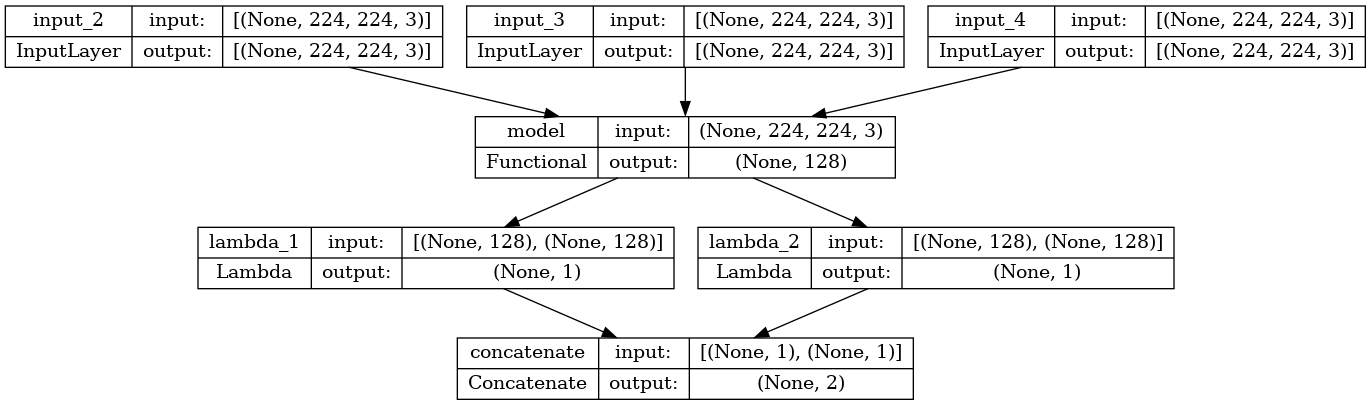

In [14]:
plot_model(siamese_model, show_shapes=True, show_layer_names=True)

In [15]:
# Instantiate the data generators
train_gen = data_generator(train_df, BATCH_SIZE)
val_gen = data_generator(val_df, BATCH_SIZE)

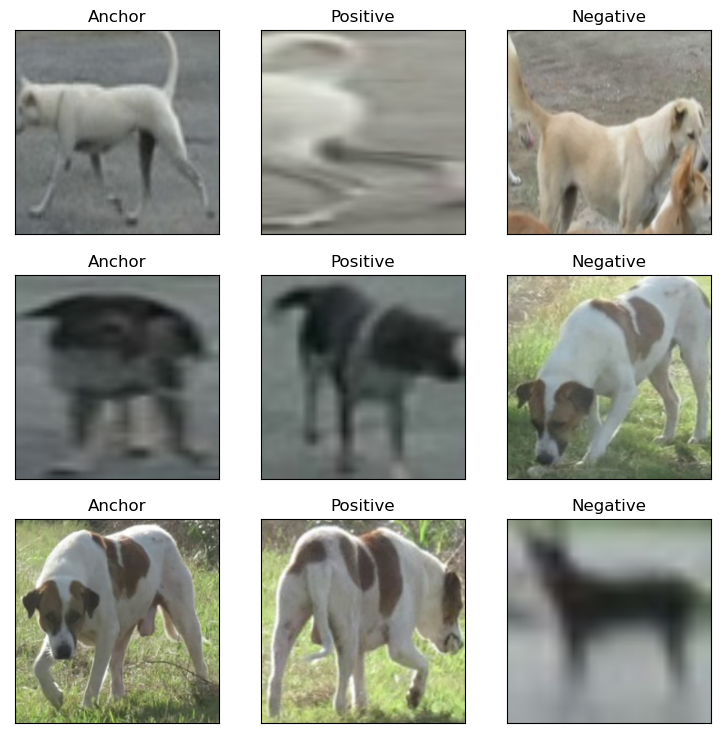

In [16]:
def visualize(anchor, positive, negative, anchor_labels, positive_labels, negative_labels):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image, label):
        ax.imshow(image)
        ax.set_title(label)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i], anchor_labels[i])
        show(axs[i, 1], positive[i], positive_labels[i])
        show(axs[i, 2], negative[i], negative_labels[i])

# Get a batch of data from the data generator
input_data, _ = next(train_gen)
anchor_batch, positive_batch, negative_batch = input_data

# Get the labels for anchor, positive, and negative images
anchor_labels = ["Anchor"] * 3
positive_labels = ["Positive"] * 3
negative_labels = ["Negative"] * 3

# Visualize the anchor, positive, and negative images with their labels
visualize(anchor_batch, positive_batch, negative_batch, anchor_labels, positive_labels, negative_labels)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Define your early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Siamese model with the learning rate scheduler and early stopping
history = siamese_model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
508/508 [==============================] - 388s 522ms/step - loss: 0.1707 - triplet_accuracy: 0.9707 - val_loss: 0.0522 - val_triplet_accuracy: 0.9969
Epoch 2/20
508/508 [==============================] - 256s 504ms/step - loss: 0.0466 - triplet_accuracy: 0.9957 - val_loss: 0.0407 - val_triplet_accuracy: 0.9937
Epoch 3/20
508/508 [==============================] - 256s 504ms/step - loss: 0.0262 - triplet_accuracy: 0.9976 - val_loss: 0.0320 - val_triplet_accuracy: 0.9976
Epoch 4/20
508/508 [==============================] - 255s 502ms/step - loss: 0.0199 - triplet_accuracy: 0.9986 - val_loss: 0.0404 - val_triplet_accuracy: 0.9913
Epoch 5/20
508/508 [==============================] - 255s 502ms/step - loss: 0.0147 - triplet_accuracy: 0.9990 - val_loss: 0.0255 - val_triplet_accuracy: 0.9953
Epoch 6/20
508/508 [==============================] - 256s 503ms/step - loss: 0.0091 - triplet_accuracy: 0.9998 - val_loss: 0.0030 - val_triplet_accuracy: 1.0000
Epoch 7/20
508/508 [========

In [18]:
print(history.history)

{'loss': [0.17068767547607422, 0.046561550348997116, 0.02617315761744976, 0.0199398472905159, 0.014744175598025322, 0.009146672673523426, 0.006039042491465807, 0.007374359294772148, 0.005554138217121363, 0.00768112950026989, 0.01090309303253889, 0.009036058560013771, 0.005066881887614727, 0.0033863738644868135], 'triplet_accuracy': [0.9706688523292542, 0.9956691861152649, 0.9976376891136169, 0.998621940612793, 0.9990156888961792, 0.9998031258583069, 0.9996062517166138, 1.0, 1.0, 0.9992125630378723, 0.9986220002174377, 0.9986220002174377, 0.9990156888961792, 0.9994094371795654], 'val_loss': [0.05217726528644562, 0.040653567761182785, 0.032022520899772644, 0.04037128761410713, 0.02548024244606495, 0.002974175615236163, 0.005881201941519976, 0.006248500198125839, 0.0001420767803210765, 0.013333394192159176, 0.02261652611196041, 0.029852040112018585, 0.004449189640581608, 0.018276112154126167], 'val_triplet_accuracy': [0.9968504309654236, 0.9937008619308472, 0.9976378083229065, 0.991338670

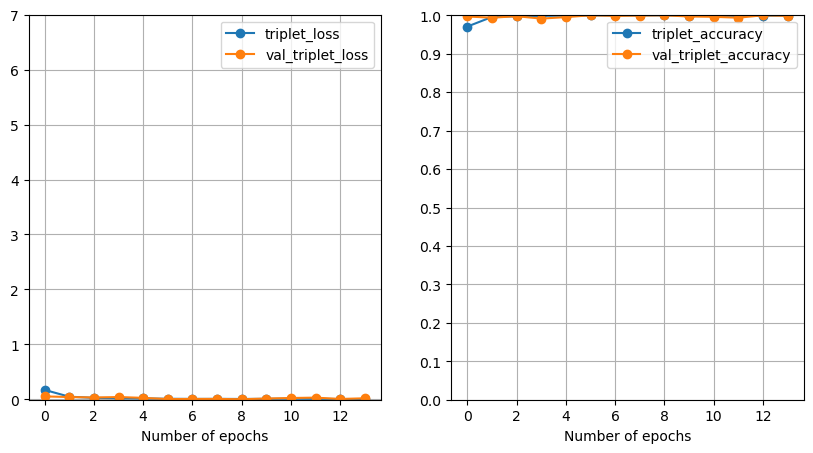

In [19]:
evaluation(history.history)

In [20]:
embedding_model.save_weights('/kaggle/working/weights_inceptionresentv2.h5')
embedding_model.save('/kaggle/working/siamese_inceptionresentv2.h5')


In [ ]:
!zip /kaggle/working/weights_inceptionresentv2.zip /kaggle/working/weights_inceptionresentv2.h5
!zip /kaggle/working/siamese_inceptionresentv2.zip /kaggle/working/siamese_inceptionresentv2.h5

In [22]:
def load_image(image_path, img_size=IMG_SIZE):
    img = plt.imread(image_path)
    img = np.array(Image.fromarray(img).resize(img_size, resample=Image.BILINEAR))
    return img / 255.0

def load_images(filepaths, img_size=IMG_SIZE):
    images = [load_image(fp, img_size=img_size) for fp in filepaths]  # Pass img_size parameter here
    return np.stack(images)

def get_all_embeddings_batched(filepaths, model, batch_size=32):
    num_images = len(filepaths)
    all_embeddings = []

    for start_idx in range(0, num_images, batch_size):
        end_idx = start_idx + batch_size
        batch_filepaths = filepaths[start_idx:end_idx]
        batch_images = load_images(batch_filepaths)
        batch_embeddings = model.predict(batch_images, verbose=0)
        all_embeddings.extend(batch_embeddings)

    return np.array(all_embeddings)

In [23]:
train_filepaths = df['filepath'].tolist()
test_filepaths = df_test['filepath'].tolist()

In [24]:
train_embeddings = get_all_embeddings_batched(train_filepaths, embedding_model)
test_embeddings = get_all_embeddings_batched(test_filepaths, embedding_model)

In [25]:
from sklearn.manifold import TSNE
import time

n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(train_embeddings) #Here

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6350 samples in 0.001s...
[t-SNE] Computed neighbors for 6350 samples in 1.166s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6350
[t-SNE] Computed conditional probabilities for sample 2000 / 6350
[t-SNE] Computed conditional probabilities for sample 3000 / 6350
[t-SNE] Computed conditional probabilities for sample 4000 / 6350
[t-SNE] Computed conditional probabilities for sample 5000 / 6350
[t-SNE] Computed conditional probabilities for sample 6000 / 6350
[t-SNE] Computed conditional probabilities for sample 6350 / 6350
[t-SNE] Mean sigma: 0.013557
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.415344
[t-SNE] KL divergence after 1000 iterations: 0.831376
t-SNE done! Time elapsed: 36.26040959358215 seconds


In [26]:
def extract_image_id(row):
    filepath = row['filepath']
    img_class = os.path.basename(os.path.dirname(filepath)).split('.')[-1]
    return img_class

In [27]:
df_test['True_DogID'] = df_test.apply(extract_image_id, axis=1)
train_filepaths = df['filepath'].tolist()
train_dog_ids = df['DogID'].tolist()
test_filepaths = df_test['filepath'].tolist()
test_dog_ids = df_test['True_DogID'].tolist()

9


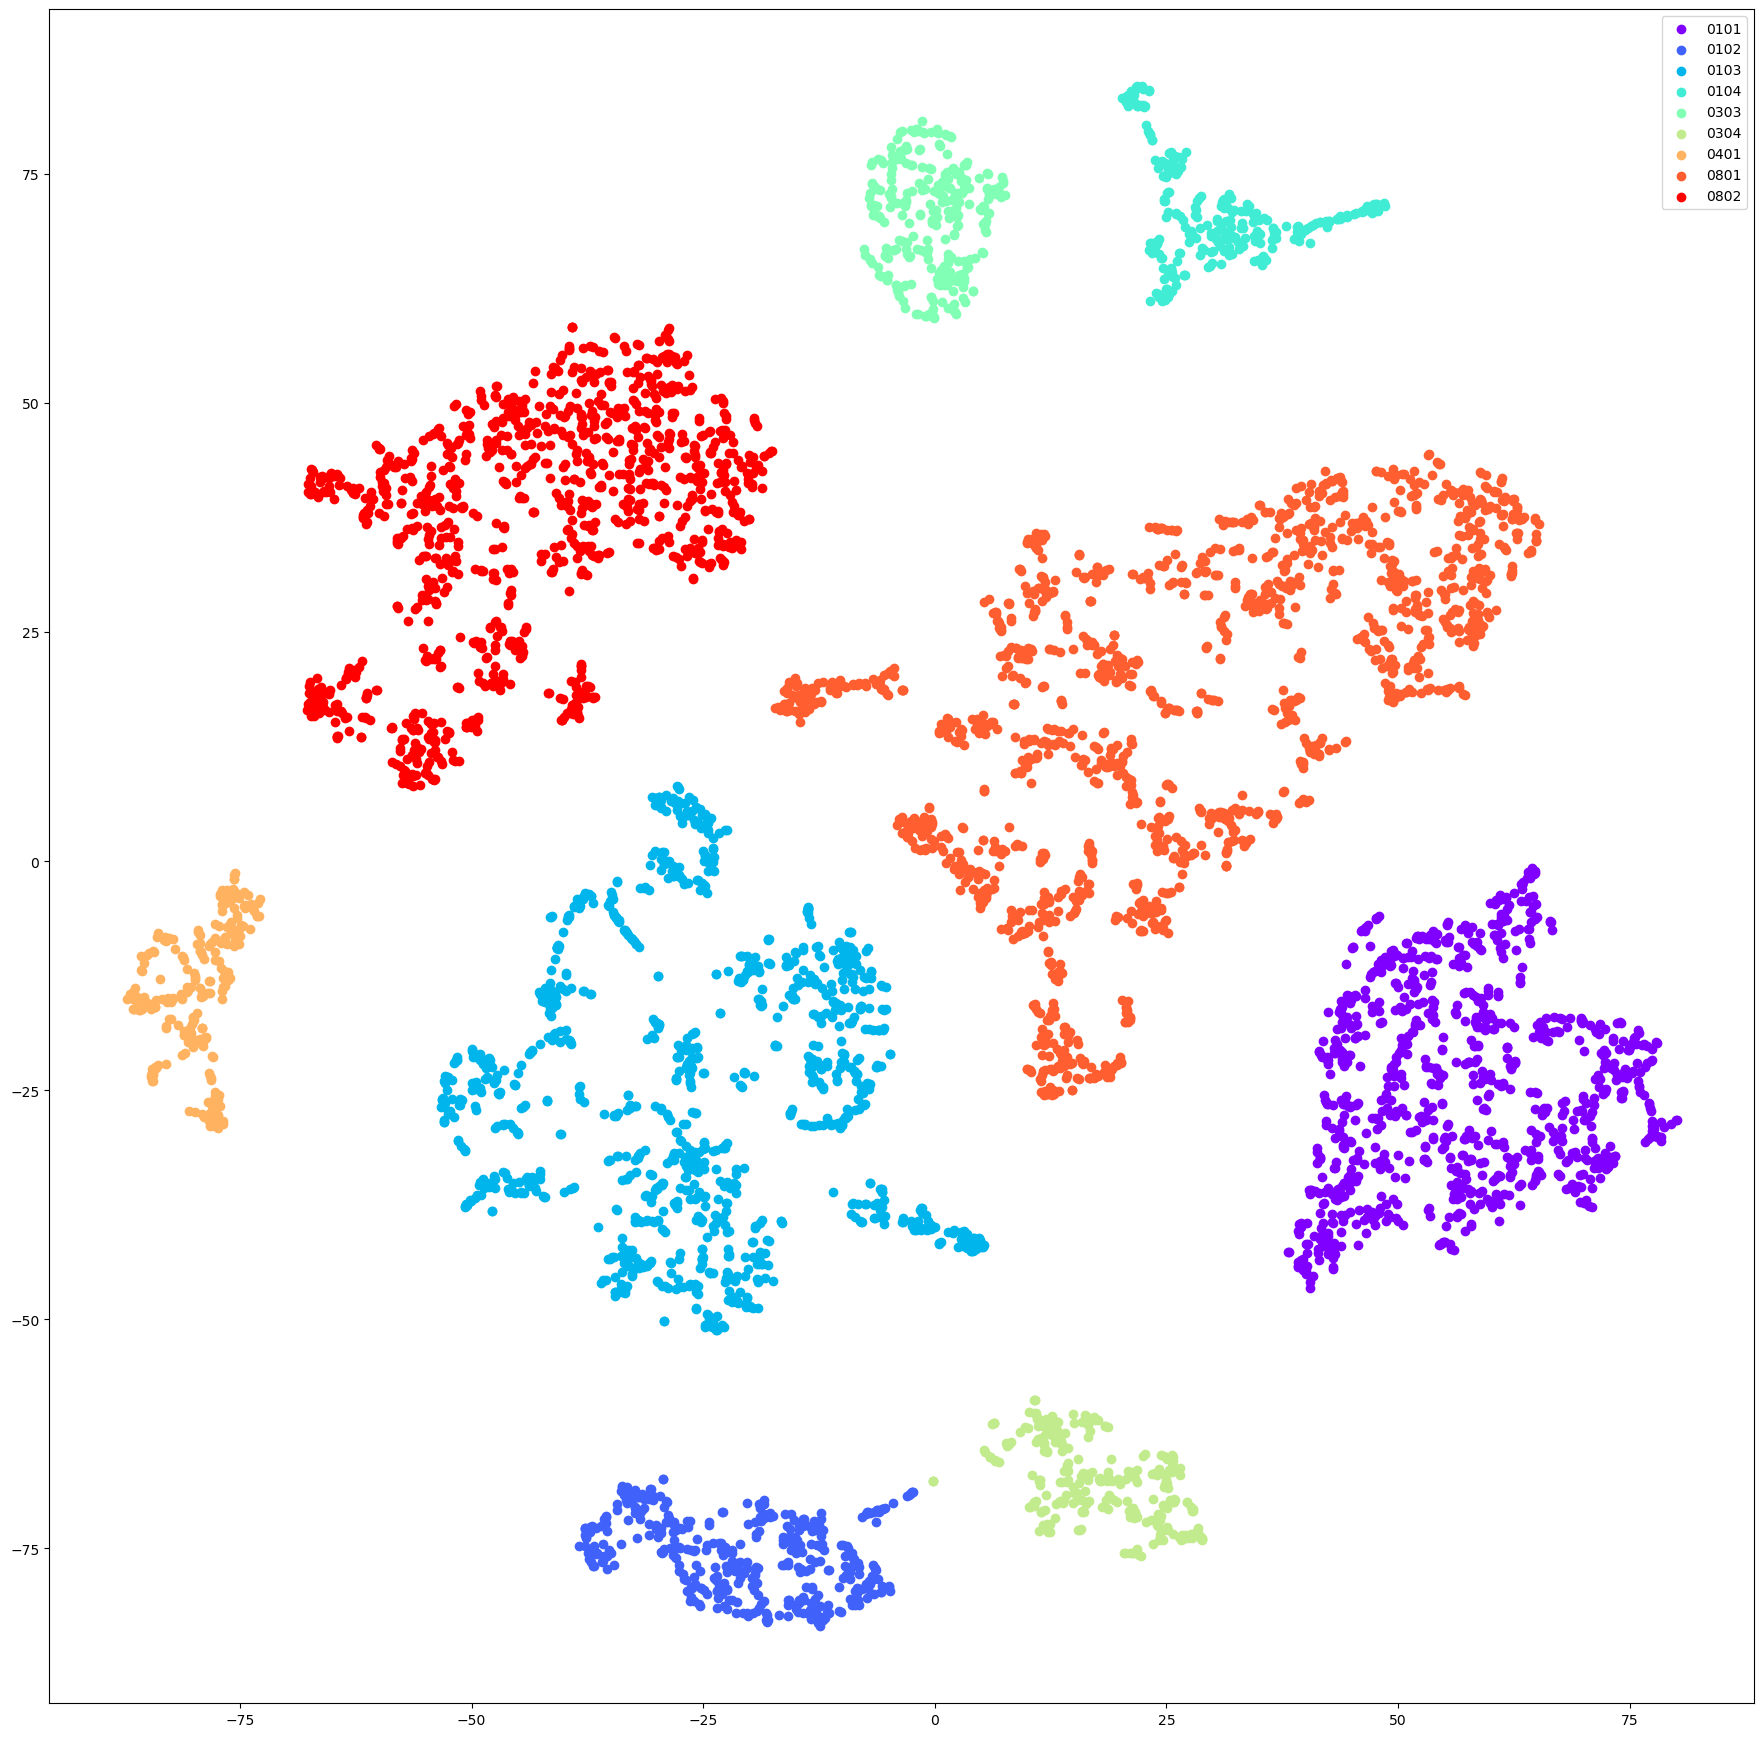

In [28]:
# Create a dictionary to map labels to colors
unique_labels = np.unique(train_dog_ids)
print(len(unique_labels))
# Create a dictionary to map labels to colors
unique_labels = np.unique(train_dog_ids)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

# Plot the t-SNE points with colors based on their labels
fig, ax = plt.subplots(figsize=(22, 22))
for label, color in label_to_color.items():
    indices = [i for i, l in enumerate(train_dog_ids) if l == label]
    ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=[color], label=label)

# Add a legend
ax.legend()
plt.show()

In [29]:
fig.savefig('/kaggle/working/train_tsne.jpg', dpi=300)

In [30]:
from sklearn.manifold import TSNE
import time

n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(test_embeddings) #Here

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3871 samples in 0.003s...
[t-SNE] Computed neighbors for 3871 samples in 0.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3871
[t-SNE] Computed conditional probabilities for sample 2000 / 3871
[t-SNE] Computed conditional probabilities for sample 3000 / 3871
[t-SNE] Computed conditional probabilities for sample 3871 / 3871
[t-SNE] Mean sigma: 0.017617
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.569534
[t-SNE] KL divergence after 1000 iterations: 0.708642
t-SNE done! Time elapsed: 21.319748640060425 seconds


9


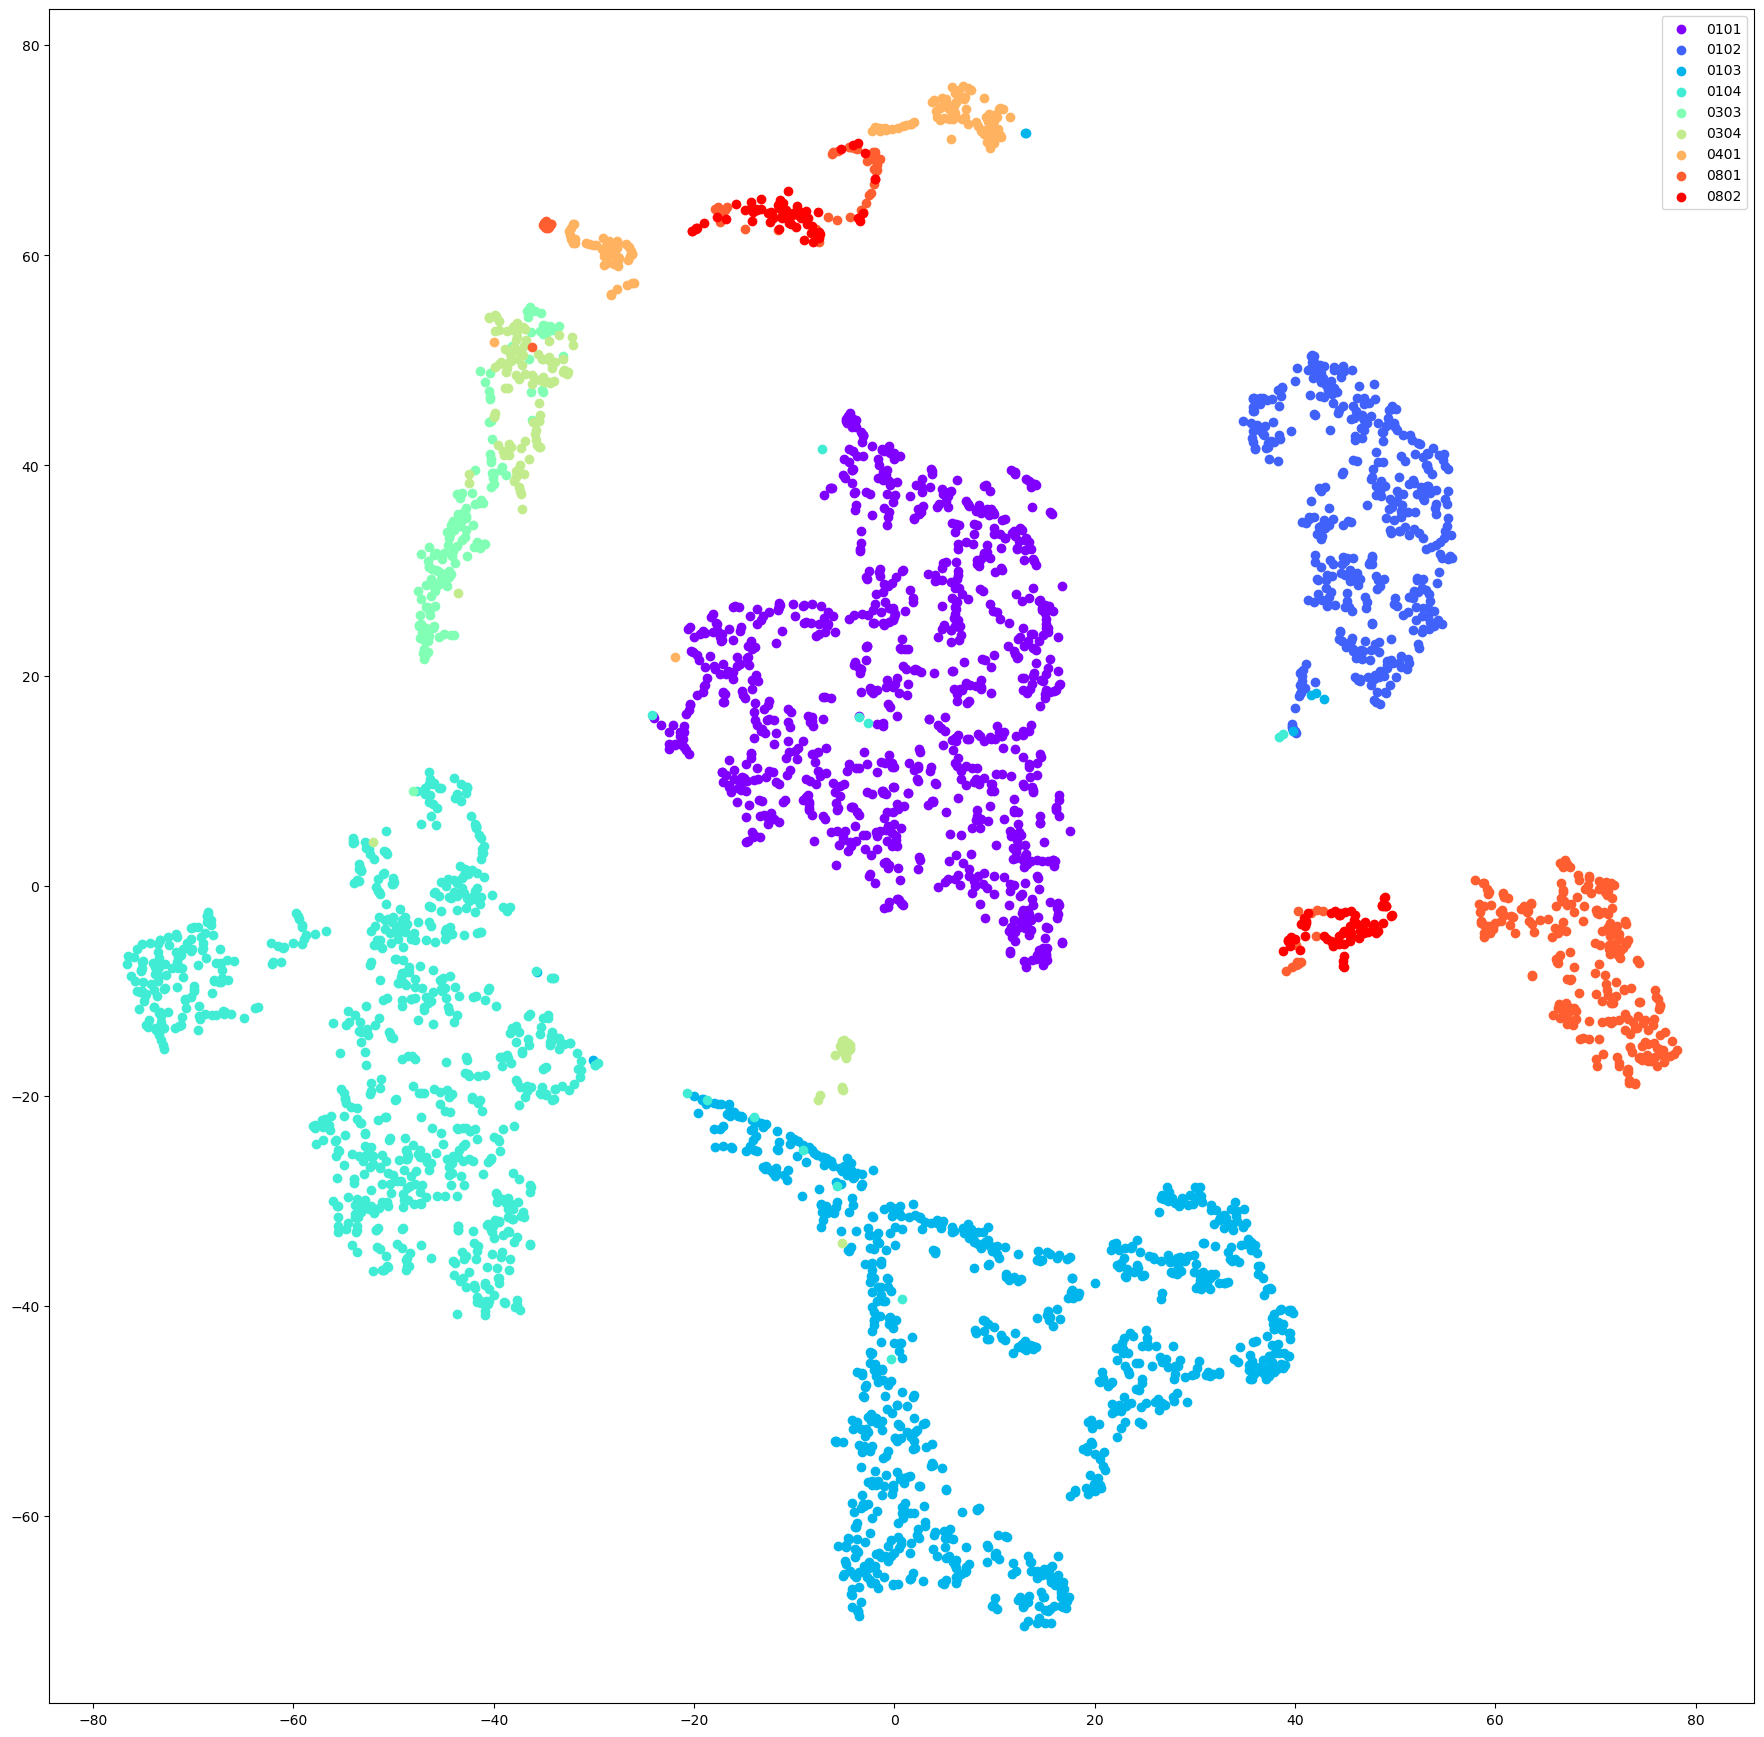

In [31]:
# Create a dictionary to map labels to colors
unique_labels = np.unique(test_dog_ids)
print(len(unique_labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

# Plot the t-SNE points with colors based on their labels
fig, ax = plt.subplots(figsize=(22, 22))
for label, color in label_to_color.items():
    indices = [i for i, l in enumerate(test_dog_ids) if l == label]
    ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=[color], label=label)

# Add a legend
ax.legend()
plt.show()

In [32]:
fig.savefig('/kaggle/working/test_tsne.jpg', dpi=300)

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

def visualize_closest_images_cosine_similarity(query_embeddings, test_embeddings, query_filepaths, test_filepaths, n_closest):
    similarities = cosine_similarity(query_embeddings, test_embeddings)
    fig, axes = plt.subplots(len(query_filepaths), n_closest + 1, figsize=(3 * (n_closest + 1), 3 * len(query_filepaths)))

    for i, query_filepath in enumerate(query_filepaths):
        query_image = Image.open(query_filepath)
        query_image.thumbnail((100, 100), Image.ANTIALIAS)
        axes[i, 0].imshow(query_image)
        axes[i, 0].set_title("Query Image")
        axes[i, 0].axis("off")

        closest_indices = np.argpartition(similarities[i], -n_closest)[-n_closest:]
        sorted_closest_indices = closest_indices[np.argsort(-similarities[i, closest_indices])]

        for j, closest_index in enumerate(sorted_closest_indices):
            test_image = Image.open(test_filepaths[closest_index])
            test_image.thumbnail((100, 100), Image.ANTIALIAS)
            axes[i, j + 1].imshow(test_image)
            axes[i, j + 1].set_title(f"Closest {j + 1}\nSimilarity: {similarities[i, closest_index]:.2f}")
            axes[i, j + 1].axis("off")

    plt.tight_layout()
    plt.show()


In [34]:
query_filepaths = [path for path in glob.glob('/kaggle/input/dogdataset/query/*.jpg', recursive = True)]
print(f"Total query images: {len(query_filepaths)}")

Total query images: 9


In [35]:
query_embeddings = get_all_embeddings_batched(query_filepaths, embedding_model)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


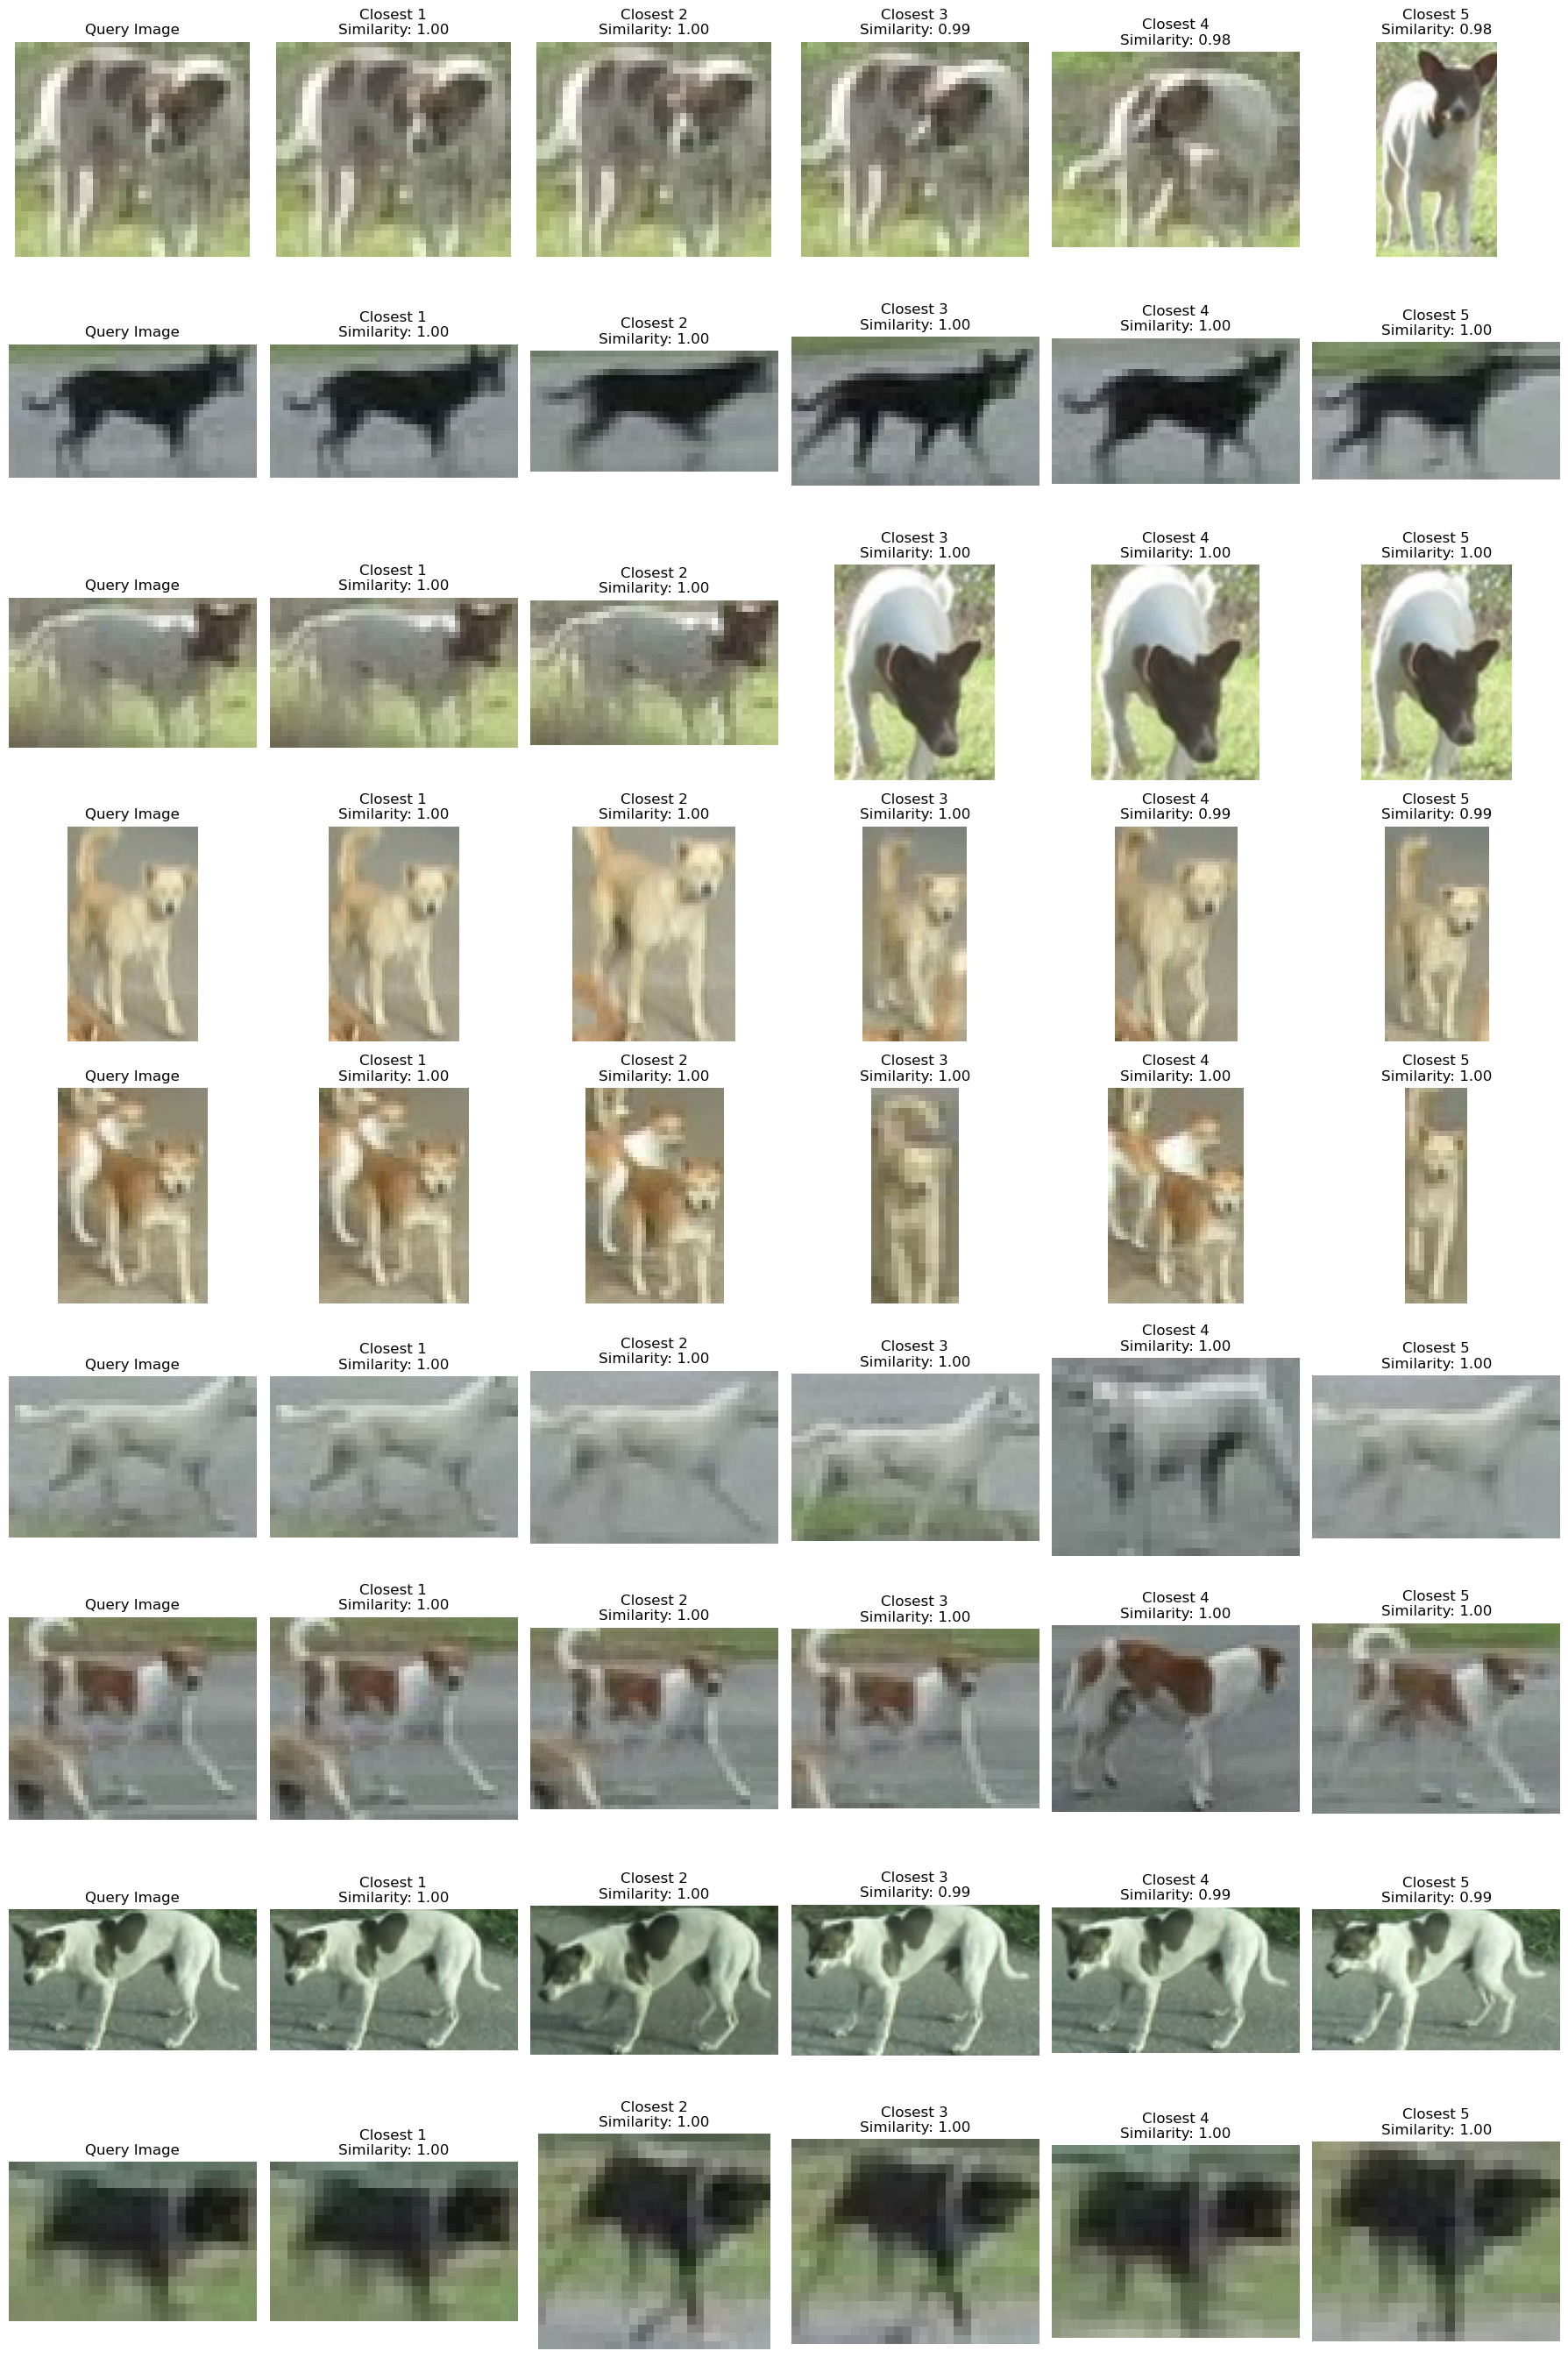

In [36]:
n_closest = 5
visualize_closest_images_cosine_similarity(query_embeddings, test_embeddings, query_filepaths, test_filepaths, n_closest)


In [37]:
df_test

,filepath,True_DogID
0,/kaggle/input/dogdataset/Gallory_diffCamera/Do...,0303
1,/kaggle/input/dogdataset/Gallory_diffCamera/Do...,0303
2,/kaggle/input/dogdataset/Gallory_diffCamera/Do...,0303
3,/kaggle/input/dogdataset/Gallory_diffCamera/Do...,0303
4,/kaggle/input/dogdataset/Gallory_diffCamera/Do...,0303
...,...,...
3866,/kaggle/input/dogdataset/Gallory_diffCamera/Do...,0101
3867,/kaggle/input/dogdataset/Gallory_diffCamera/Do...,0101
3868,/kaggle/input/dogdataset/Gallory_diffCamera/Do...,0101
3869,/kaggle/input/dogdataset/Gallory_diffCamera/Do...,0101


In [38]:
test_filepaths = df_test['filepath'].tolist()
true_labels = df_test['True_DogID'].tolist()

similarity_matrix = cosine_similarity(test_embeddings)

In [39]:
from sklearn.metrics import roc_curve, auc, accuracy_score

def get_binary_labels(true_labels):
    num_samples = len(true_labels)
    binary_labels = np.zeros((num_samples, num_samples), dtype=bool)
    for i in range(num_samples):
        for j in range(num_samples):
            binary_labels[i, j] = true_labels[i] == true_labels[j]
    return binary_labels

binary_labels = get_binary_labels(true_labels)
binary_labels_flat = binary_labels.flatten()

thresholds = np.linspace(0, 1, num=200)
best_threshold = 0
best_acc = 0

for threshold in thresholds:
    pred_labels_flat = similarity_matrix.flatten() > threshold
    acc = accuracy_score(binary_labels_flat, pred_labels_flat)
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

print("Best threshold:", best_threshold)
print("Best accuracy:", best_acc)


Best threshold: 0.7336683417085427
Best accuracy: 0.9782764231722335


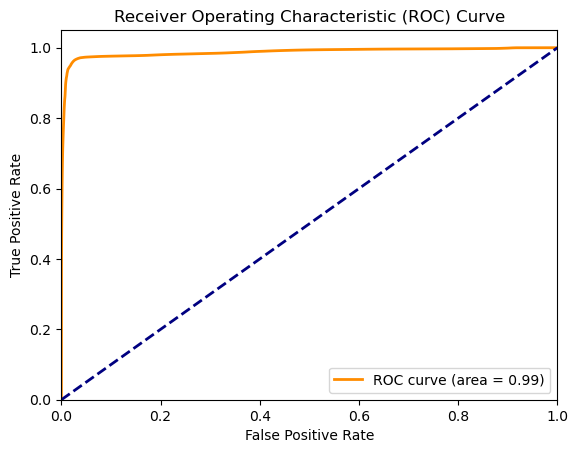

In [47]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(binary_labels_flat, similarity_matrix.flatten())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
def average_precision(ranked_labels, true_label, rank):
    correct_label_count = 0
    ap_sum = 0
    for i, label in enumerate(ranked_labels[:rank]):
        if label == true_label:
            correct_label_count += 1
            ap_sum += correct_label_count / (i + 1)
    return ap_sum / correct_label_count if correct_label_count > 0 else 0

def mean_average_precision(similarity_matrix, true_labels, ranks):
    num_queries = len(true_labels)
    map_values = []
    
    for rank in ranks:
        ap_values = []
        for query_idx in range(num_queries):
            query_similarities = similarity_matrix[query_idx]
            sorted_indices = np.argsort(-query_similarities)  # Sort in descending order
            ranked_labels = [true_labels[i] for i in sorted_indices]
            ap = average_precision(ranked_labels, true_labels[query_idx], rank)
            ap_values.append(ap)
        map_values.append(np.mean(ap_values))
    return map_values

ranks = [1, 5, 10, 50, 1000]
map_values = mean_average_precision(similarity_matrix, df_test['True_DogID'], ranks)

for rank, map_value in zip(ranks, map_values):
    print(f"MAP@{rank}: {map_value:.4f}")


MAP@1: 1.0000
MAP@5: 0.9967
MAP@10: 0.9922
MAP@50: 0.9754
MAP@1000: 0.9246


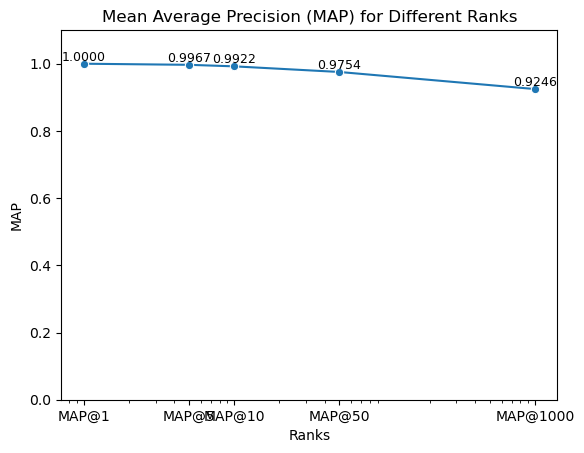

In [43]:
data = pd.DataFrame({'Ranks': ranks, 'MAP': map_values})
plt.figure()
sns.lineplot(data=data, x='Ranks', y='MAP', marker='o')

# Set the y-axis limits to be between 0 and 1
plt.ylim(0, 1.1)

# Set the x-axis to logarithmic scale
plt.xscale('log')

# Customize the x-axis ticks and labels
plt.xticks(ranks, [f'MAP@{rank}' for rank in ranks])

# Add the title
plt.title('Mean Average Precision (MAP) for Different Ranks')

# Add the MAP values as labels on the plot
for i, value in enumerate(map_values):
    plt.text(ranks[i], value + 0.01, f"{value:.4f}", ha='center', fontsize=9)

plt.savefig('/kaggle/working/map.jpg')

In [45]:
converter = tf.lite.TFLiteConverter.from_keras_model(embedding_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('/kaggle/working/embedding_model.tflite', 'wb') as f:
    f.write(tflite_model)